<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install keras-tuner

In [75]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from sklearn.preprocessing import OneHotEncoder
from kerastuner.tuners import Hyperband
from kerastuner import HyperParameters
from keras.optimizers import Adam, Adadelta, Adagrad, RMSprop
from keras.activations import sigmoid, relu, tanh
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score,classification_report, \
confusion_matrix
import matplotlib.pyplot as plt

In [4]:
cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'Adadelta',
           'Adagrad',
           'RMSprop'   
]
activations = ['relu', 'tanh', 'sigmoid']

In [5]:
data = pd.read_csv(data_path)[cols]

In [6]:
data.sample(5)

,text,target
40857,holds posters on wall for NUMBER minutes do no...,0
160620,adorable winnie the pooh cake this cake is rea...,1
260113,great introduction to databases if you are new...,1
317634,great saw this saw was amazingly accurate out ...,1
226443,disappointed this arrived broken into tiny pie...,0


In [7]:
test = pd.read_csv(test_path)[cols]

In [8]:
test.sample(5)

,text,target
8866,masterful suspense and an edgy hero kay david ...,1
12274,normal happiness the second release in a calen...,1
6734,gimmicky this performance is a cutesy one repl...,0
8899,good quick read but wait till paperback or lib...,0
19095,false belief system amazing that in our times ...,0


In [9]:
train, val = train_test_split(data, test_size=0.15, stratify=data['target'], random_state=seed)

In [10]:
train.shape, val.shape

((305988, 2), (53998, 2))

## Training

In [ ]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [17]:
def get_sequences(tokenizer, max_len, texts):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=max_len)

In [ ]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

In [ ]:
sequence_train.shape, sequence_val.shape

((305988, 250), (53998, 250))

In [ ]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [18]:
OH_encoder = OneHotEncoder(sparse=False)
train_target = OH_encoder.fit_transform(train['target'].values.reshape(-1,1))
val_target = OH_encoder.transform(val['target'].values.reshape(-1,1))

In [19]:
train_target.shape, val_target.shape

((305988, 2), (53998, 2))

In [20]:
def get_optimizer(key):
  map = {
      'Adam': Adam(),
      'Adadelta': Adadelta(),
      'Adagrad': Adagrad(),
      'RMSprop': RMSprop()
  }
  return map.get(key)

In [21]:
def build_simple_mlp(hp):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    model.add(Dense(hp.get('hidden_units'),\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=hp.get('optimizer'),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [23]:
hp = HyperParameters()
hp.Int('hidden_units', 10, 30, 10)
hp.Choice('hidden_activation', activations)
hp.Choice('optimizer', optimizers)

'Adam'

In [24]:
tuner = Hyperband(
    build_simple_mlp,
    max_epochs=10,
    objective='val_loss',
    executions_per_trial=2,
    directory='/content/drive/MyDrive/sentiment/MLP',
    project_name='MLP_1H_B32',
    hyperparameters=hp,
)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/sentiment/MLP/MLP_1H_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2510      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/sentiment/MLP/MLP_1H_B32/tuner0.json


## Fit

In [ ]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=10,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 30 Complete [00h 16m 47s]
val_loss: 0.693591445684433

Best val_loss So Far: 0.6891161203384399
Total elapsed time: 03h 23m 25s
INFO:tensorflow:Oracle triggered exit


## Summary

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 10, 'sampling': None}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'Adadelta', 'Adagrad', 'RMSprop'], 'ordered': False}


In [25]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/MLP/MLP_1H_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_units: 10
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6891161203384399
Trial summary
Hyperparameters:
hidden_units: 30
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: c37ca39be27500401abcb9ef7b9de072
Score: 0.689337432384491
Trial summary
Hyperparameters:
hidden_units: 20
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: afb8e4350d472e9bb627c5ae6873135e
Score: 0.6895457804203033


In [ ]:
best_params = tuner.get_best_hyperparameters(1)[0]
print(f"hidden units best: {best_params.get('hidden_units')}")
print(f"hidden activation best: {best_params.get('hidden_activation')}")
print(f"optimizer best: {best_params.get('optimizer')}")

hidden units best: 10
hidden activation best: sigmoid
optimizer best: RMSprop


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2510      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________


In [ ]:
best_model.evaluate(sequence_train, train_target, batch_size=32)

9563/9563 [==============================] - 42s 4ms/step - loss: 0.6897 - accuracy: 0.5345 - precision: 0.5345 - recall: 0.5345 - true_positives: 81782.4235 - true_negatives: 81782.4235 - false_positives: 71257.5673 - false_negatives: 71257.5673


[0.6896055340766907,
 0.5350667238235474,
 0.5350667238235474,
 0.5350667238235474,
 163724.0,
 163724.0,
 142264.0,
 142264.0]

In [ ]:
best_model.evaluate(sequence_val, val_target, batch_size=32)

1688/1688 [==============================] - 7s 4ms/step - loss: 0.6891 - accuracy: 0.5376 - precision: 0.5376 - recall: 0.5376 - true_positives: 29028.0000 - true_negatives: 29028.0000 - false_positives: 24970.0000 - false_negatives: 24970.0000


[0.6890584230422974,
 0.5375754833221436,
 0.5375754833221436,
 0.5375754833221436,
 29028.0,
 29028.0,
 24970.0,
 24970.0]

In [ ]:
# with open('/content/drive/MyDrive/sentiment/MLP/MLP_1H_B32/tokenizer.pickle',
#           'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Prediction

In [ ]:
to_predict = [
              'I love my job',
              'I sometimes feel unhappy',
              'I am quite excited for the work',
              'This is quite astounding',
              'get lost',
              'do not test my patience',
              'I am warning you better not destroy it for God sake'
]

category = [0,1]
for result in best_model.predict(get_sequences(tokenizer,max_len,to_predict)):
  if np.argmax(result) == 0:
    category = [1,0]
  if OH_encoder.inverse_transform([category]) == 1:
    print('positive', result)
  else:
    print('negative', result)

positive [0.43479195 0.565208  ]
positive [0.43458408 0.5654159 ]
positive [0.42525157 0.57474846]
positive [0.46718034 0.5328196 ]
positive [0.46080282 0.5391972 ]
positive [0.43458408 0.5654159 ]
positive [0.42525157 0.57474846]


## Testing

In [26]:
test_target = OH_encoder.transform(test['target'].values.reshape(-1,1))

In [15]:
old_tokenizer = pickle.load(
    open(
        '/content/drive/MyDrive/sentiment/MLP/MLP_1H_B32/tokenizer.pickle',
         'rb'
    )
)

In [42]:
def get_callbacks(file_path):
  return [
          EarlyStopping(monitor='val_loss', patience=5, mode='min', \
                        restore_best_weights=True),
          ModelCheckpoint(file_path, monitor='val_loss', verbose=1, \
                          save_best_only=True,  mode='min')
  ]

In [58]:
m = tuner.get_best_models(num_models=1)[0]
model = Sequential().from_config(m.get_config())
model.compile(
    optimizer=tuner.get_best_hyperparameters()[0].get('optimizer'),
    loss='categorical_crossentropy',
    metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2510      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________


In [45]:
train_seq = get_sequences(
        old_tokenizer,
        config["layers"][0]["config"]["batch_input_shape"][1],
        train['text']
      )
val_seq = get_sequences(
        old_tokenizer,
        config["layers"][0]["config"]["batch_input_shape"][1],
        val['text']
      )
test_seq = get_sequences(
        old_tokenizer,
        config["layers"][0]["config"]["batch_input_shape"][1],
        test['text']
      )

In [61]:
history = model.fit(
    train_seq,
    train_target,
    validation_data=(val_seq, val_target),
    epochs=100,
    callbacks=get_callbacks('simple_mlp2.h5')
)

Epoch 1/100
9563/9563 [==============================] - 54s 6ms/step - loss: 0.6900 - accuracy: 0.5346 - precision_1: 0.5346 - recall_1: 0.5346 - true_positives_1: 163572.0000 - true_negatives_1: 163572.0000 - false_positives_1: 142416.0000 - false_negatives_1: 142416.0000 - val_loss: 0.6895 - val_accuracy: 0.5374 - val_precision_1: 0.5374 - val_recall_1: 0.5374 - val_true_positives_1: 29020.0000 - val_true_negatives_1: 29020.0000 - val_false_positives_1: 24978.0000 - val_false_negatives_1: 24978.0000

Epoch 00001: val_loss improved from inf to 0.68950, saving model to simple_mlp2.h5
Epoch 2/100
9563/9563 [==============================] - 53s 6ms/step - loss: 0.6900 - accuracy: 0.5349 - precision_1: 0.5349 - recall_1: 0.5349 - true_positives_1: 163662.0000 - true_negatives_1: 163662.0000 - false_positives_1: 142326.0000 - false_negatives_1: 142326.0000 - val_loss: 0.6893 - val_accuracy: 0.5377 - val_precision_1: 0.5377 - val_recall_1: 0.5377 - val_true_positives_1: 29036.0000 - val_t

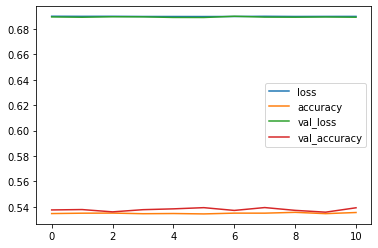

In [63]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history.history)[metr].plot()

In [65]:
# pickle.dump(
#     history.history,
#     open('/content/drive/MyDrive/sentiment/MLP/MLP_1H_B32/history.pickle', 
#     'wb')
#     )

In [69]:
model.evaluate(test_seq, test_target, batch_size=32)

625/625 [==============================] - 3s 5ms/step - loss: 0.6895 - accuracy: 0.5351 - precision_1: 0.5351 - recall_1: 0.5351 - true_positives_1: 10702.0000 - true_negatives_1: 10702.0000 - false_positives_1: 9298.0000 - false_negatives_1: 9298.0000


[0.6895309686660767,
 0.535099983215332,
 0.535099983215332,
 0.535099983215332,
 10702.0,
 10702.0,
 9298.0,
 9298.0]

In [82]:
def model_evaluate(model,X_test,y_test,batch_size):
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Purples, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

168/625 [=======>......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 1s 912us/step
Accuracy:	53.5%


              precision    recall  f1-score   support

           0       0.53      0.70      0.60     10000
           1       0.55      0.37      0.44     10000

    accuracy                           0.54     20000
   macro avg       0.54      0.54      0.52     20000
weighted avg       0.54      0.54      0.52     20000



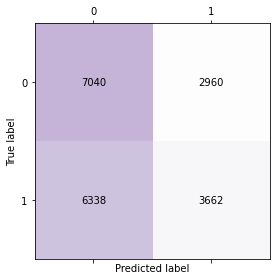

In [83]:
model_evaluate(model, test_seq, test_target, 32)